# ANLP 2017 - Assignment 4


Kuan Yu, 792917

<div class="alert alert-block alert-danger">Due: Tuesday, December 19</div>

<div class="alert alert-block alert-info">
**NOTE**<br><br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-4.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload. In case of questions, you can contact Tatjana or Jens via email, or via the Moodle forum (preferred).
</div>

<div class="alert alert-block alert-info">
In this assignment we are exploring the evaluation of statistical phrase structure parsers.
<br><br>
We will use the development section of the Penn Treebank. We provide gold parses (`.gold`), automatic parses (`.berkeley`; see below) as well as the pre-tokenized raw data (`.text`). Each file contains one section, as one sentence per line. The text files are pre-tokenized using white space.
</div>

## Problem 1: Reimplement EVALB

<div class="alert alert-block alert-info">
Standardly, phrase structure parsers are evaluated with the Parseval metric EVALB, which computes labelled and unlabelled precision, recall, and F1-scores over the brackets in a phrase structure parse. You can find the standard tool at (http://nlp.cs.nyu.edu/evalb/). Get to know EVALB, especially its parameter file syntax; take a look at the examples they provided (`COLLINS.prm` and `new.prm`).
<br><br>
A quick technical sidenote: EVALB was written in C, almost twenty years ago, and if you want to try it out you will have to compile it yourself on your own system, which requires a C compiler. You may have to remove the line `#include <malloc.h>` from `evalb.c` to make it work with a modern compiler. For a successful completion of this assignment, it is not necessary to compile and install EVALB, though it is helpful for comparison.
<br><br>
Then reimplement labelled and unlabelled precision, recall and F1 in Python. Please do NOT use EVALB's C code as your example for reimplementation. Instead, consult the lecture slides for the definitions. In order to represent the trees, you may use NLTK’s `Tree` class, but note that it doesn’t keep track of the leaves’ string indices, so it may not be easy to distinguish where you are in a sentence like “The man with the hat hit the man with the shovel”.
<br><br>
It may be easier to implement your own recursive tree data structures and make sure to keep track of the string indices of the leaf nodes directly. Your data structure should be able to read in bracketed trees.

**Notes on EVALB**: Some pre- or postprocessing may be necessary on the trees to compare them. Note in particular that some trees contain an additional ROOT or TOP node which should not be part of the evaluation.
<br><br>
Please make sure that your evaluation script only compares the first part of the label (e.g., NP for NP-SBJ, etc.). Any remainder should be stripped before evaluating (they have been stripped from the gold data). By convention, POS tags are not compared (not even for labelled prec and recall).
<br><br>
The gold parse trees contain empty categories (traces), which have the label (POS tag) “-NONE-”. You should remove all such traces and any nodes that contain nothing but traces before evaluating. For example,
`... (VP (VBD reported) (SBAR (-NONE- 0) (S (-NONE- *T*-1)))) (. .)))` would be processed to give `... (VP (VBD reported)) (. .)))`
<br><br>
Run your evalb implementation on the provided test set. It was produced using the Berkeley parser: https://github.com/slavpetrov/berkeleyparser.
<div>

In [1]:
import re


def parse_ptb(line, line_id= 0
              , normalize= None
              , label= re.compile("\w*")
              , unpack= re.compile("ROOT|TOP")
              , delete= re.compile("-NONE-")):
    """returns a ptb parse tree from `line` which may be a multi-line
    string but must contain only one tree (top level bracket).

    non-terminal symbols will be indexed by their positions in the
    sentence, and prepended by `line_id`, after being normalized by
    function `normalize: str -> str`.

    terminal symbols are retrieved by taking the first result produced
    by `label.search`.  when fullmatched by `delete`, the entire node
    is removed.  when fullmatched by `unpack`, only the terminal
    symbol is removed, the children nodes are unpacked into the
    higher-level node.

    """
    if not normalize: normalize = lambda x: x
    stack, symbol, term_id = [[]], [], 0
    for char in line:
        if char.isspace():
            if symbol: # symbol is a non-terminal
                stack[-1].append("".join(symbol))
                symbol = []
        elif ")" == char:
            node = stack.pop()
            head = node[0]
            if isinstance(head, tuple): # dummy node
                assert not symbol
                stack[-1].extend(node)
            elif re.fullmatch(delete, head):
                symbol = []
                pass
            else:
                if symbol: # symbol is a terminal
                    node.append("{}.{} {}".format(line_id, term_id, normalize("".join(symbol))))
                    symbol = []
                    term_id += 1
                if 1 == len(node): # node is empty due to delete
                    pass
                elif re.fullmatch(unpack, head):
                    stack[-1].extend(node[1:])
                else:
                    node[0] = re.search(label, head).group()
                    stack[-1].append(tuple(node))
        elif "(" == char:
            assert not symbol
            stack.append([])
        else:
            symbol.append(char)
    res = stack.pop()
    assert (not symbol) and (not stack) and (1 == len(res))
    return res[-1]


def load_ptb(file, skip_err= True, verbose= True, **kwargs):
    """yields ptb trees in `file`.

    if `skip_err`, yields an empty tree when a line cannot be parsed.
    otherwise raise the error.

    if `verbose`, prints info for parsing errors.

    any additional keyword arguments will be given to `parse_ptb`.

    """
    with open(file, encoding= 'utf-8') as file:
        for i, line in enumerate(file):
            try:
                tree = parse_ptb(line, line_id= i, **kwargs)
            except Exception as err:
                if verbose:
                    print("failed to parse line {}: {}".format(i, line), end= '')
                if skip_err:
                    yield ()
                else:
                    raise err
            else:
                yield tree

In [2]:
s = "( (S (ROOT (VP-STUFF (VBD Reported) (SBAR (-NONE- 0) (S (-NONE- *T*-1)))) (. .))))"
print("""
* test parse_ptb on

- delete -NONE-
- unwrap ROOT
- unwrap dummy root
- normalize symbols

** line

{}

** tree

{}""".format(s, parse_ptb(s)))


* test parse_ptb on

- delete -NONE-
- unwrap ROOT
- unwrap dummy root
- normalize symbols

** line

( (S (ROOT (VP-STUFF (VBD Reported) (SBAR (-NONE- 0) (S (-NONE- *T*-1)))) (. .))))

** tree

('S', ('VP', ('VBD', '0.0 Reported')), ('', '0.1 .'))


In [3]:
from collections import namedtuple, Counter, defaultdict


Cons = namedtuple('Cons', 'span label count')
Cons.default = Cons(span= (), label= '', count= 0)


def constituents(tree, labeled= True, counted= True, orphan= '????'):
    """yields constituents in `tree`.  each constituent is a namedtuple of
    terminal symbols `span: (tuple str)`, the non-terminal symbol
    `label: str`, and an additional identifier `count: int`.

    postag nodes do not count as constituents.  so `tree` should not
    be a preterminal node such as `(VBD Telecussed)`.  nevertheless,
    should that happen, the tree is wrapped in an `orphan` node like
    `(???? (VBD Telecussed))`.

    """
    assert isinstance(tree, tuple)
    if not tree: return
    # tree should not be a terminal derivation, nevertheless
    if isinstance(tree[-1], str): tree = orphan, tree
    if counted: counter = Counter()
    span = []
    for sub in tree[1:]:
        if isinstance(sub[-1], str): # sub is a terminal derivation
            span.append(sub[-1])
        else: # sub is a non-terminal derivation
            for cons in constituents(sub, labeled= labeled, counted= False):
                if counted:
                    yield cons._replace(count= counter[cons])
                    counter[cons] += 1
                else:
                    yield cons
            span.extend(cons.span)
    cons = Cons(count= 0, span= tuple(span), label= tree[0] if labeled else '')
    if counted: cons = cons._replace(count= counter[cons])
    yield cons


def span(tree):
    """returns the span of non-terminals (tuple str) covered by `tree`."""
    cons = Cons.default
    for cons in constituents(tree, labeled= False, counted= False): pass
    return cons.span


def match(gold, test, verbose= True):
    """yields ptb trees in `test`.  trees in `gold` and `test` are
    compared in sequence.  if their non-terminals match up, yields the
    test tree, otherwise yields an empty tree.

    """
    assert len(gold) == len(test)
    for i, (g, t) in enumerate(zip(gold, test)):
        if span(g) == span(t):
            yield t
        else:
            if verbose:
                print("sent {} mismatch in gold and test".format(i))
            yield ()

In [4]:
s = "(S (A (P this)) (B (Q is) (A (A (C (A (A (R a) (T test))))))))"
p = parse_ptb(s)
print("""
* test constituents on

- labeling
- counting

** tree

{}""".format(p))
print("\n** labeled\n")
for c in constituents(p): print(c)
print("\n** unlabeled\n")
for c in constituents(p, labeled= False): print(c)


* test constituents on

- labeling
- counting

** tree

('S', ('A', ('P', '0.0 this')), ('B', ('Q', '0.1 is'), ('A', ('A', ('C', ('A', ('A', ('R', '0.2 a'), ('T', '0.3 test'))))))))

** labeled

Cons(span=('0.0 this',), label='A', count=0)
Cons(span=('0.2 a', '0.3 test'), label='A', count=0)
Cons(span=('0.2 a', '0.3 test'), label='A', count=1)
Cons(span=('0.2 a', '0.3 test'), label='C', count=0)
Cons(span=('0.2 a', '0.3 test'), label='A', count=2)
Cons(span=('0.2 a', '0.3 test'), label='A', count=3)
Cons(span=('0.1 is', '0.2 a', '0.3 test'), label='B', count=0)
Cons(span=('0.0 this', '0.1 is', '0.2 a', '0.3 test'), label='S', count=0)

** unlabeled

Cons(span=('0.0 this',), label='', count=0)
Cons(span=('0.2 a', '0.3 test'), label='', count=0)
Cons(span=('0.2 a', '0.3 test'), label='', count=1)
Cons(span=('0.2 a', '0.3 test'), label='', count=2)
Cons(span=('0.2 a', '0.3 test'), label='', count=3)
Cons(span=('0.2 a', '0.3 test'), label='', count=4)
Cons(span=('0.1 is', '0.2 a', '0.3 te

In [5]:
def partition(it, f):
    """-> defaultdict b (set a), where it: iterable a, f: a -> b

    returns the partition of elements in `it` by the equivalence
    kernel of `f`.

    """
    res = defaultdict(set)
    for x in it: res[f(x)].add(x)
    return res


def precision(gold, test):
    """returns the precision of `test` set on `gold` set."""
    assert isinstance(gold, set)
    assert isinstance(test, set)
    try:
        return sum(x in gold for x in test) / len(test)
    except ZeroDivisionError:
        return 0.0


def recall(gold, test):
    """returns the recall of `test` set on `gold` set."""
    return precision(test, gold)


def f1(p, r):
    """returns the f1 score given precision `p` and recall `r`."""
    try:
        return 2 * p * r / (p + r)
    except ZeroDivisionError:
        return 0.0


import pandas as pd
pd.options.display.width = 250
pd.options.display.float_format = "{:.4f}".format


def metrics(gold, test, by= None):
    """returns a pandas DataFrame with `f1`, `prec`, and `recall` scores.
    `gold` and `test` need not be sets, but they will be partitioned
    by the equivalence kernel of `by`, so duplicates will not be
    counted.  each equivalence class gets a row.

    """
    if by is None: by = lambda _: ''
    gold = partition(gold, by)
    test = partition(test, by)
    rows = tuple({*gold, *test})
    p = [precision(gold[row], test[row]) for row in rows]
    r = [recall(gold[row], test[row]) for row in rows]
    f = [f1(p, r) for p, r in zip(p, r)]
    return pd.DataFrame(data= {'f1': f, 'prec': p, 'recall': r}, index= rows)

In [6]:
print("\n* test load_ptb and metrics agains evalb\n")
gold = tuple(load_ptb("EVALB/sample/sample.gld", normalize= str.lower))
test = tuple(load_ptb("EVALB/sample/sample.tst", normalize= str.lower))
test = tuple(match(gold, test))

print("\n** scores per sentence\n")
print(pd.concat(
    (metrics(constituents(g), constituents(t)) for g, t in zip(gold, test))
    , ignore_index= True))

print("\n** scores macro-averaged\n")
print(metrics(
    gold= {c for t in gold for c in constituents(t)}
    , test= {c for t in test for c in constituents(t)}))


* test load_ptb and metrics agains evalb

failed to parse line 7: (P this) (Q is) (R a) (T test)
failed to parse line 10: 
failed to parse line 13: 
sent 7 mismatch in gold and test
sent 10 mismatch in gold and test
sent 11 mismatch in gold and test
sent 12 mismatch in gold and test
sent 13 mismatch in gold and test
sent 15 mismatch in gold and test
sent 16 mismatch in gold and test
sent 19 mismatch in gold and test

** scores per sentence

       f1   prec  recall
0  1.0000 1.0000  1.0000
1  0.7500 0.7500  0.7500
2  1.0000 1.0000  1.0000
3  0.7500 0.7500  0.7500
4  0.7500 0.7500  0.7500
5  0.5714 0.6667  0.5000
6  0.4000 1.0000  0.2500
7  0.0000 0.0000  0.0000
8  0.8889 0.8000  1.0000
9  0.6667 0.5000  1.0000
10 0.0000 0.0000  0.0000
11 0.0000 0.0000  0.0000
12 0.0000 0.0000  0.0000
13 0.0000 0.0000  0.0000
14 1.0000 1.0000  1.0000
15 0.0000 0.0000  0.0000
16 0.0000 0.0000  0.0000
17 1.0000 1.0000  1.0000
18 1.0000 1.0000  1.0000
19 0.0000 0.0000  0.0000
20 1.0000 1.0000  1.0000
21 1

<div class="alert alert-block alert-info">
Provide a brief discussion of the findings.
</div>

My sentence-wise precision and recall scores match the results in `EVALB/sample/sample.rsl`, my macro-averaged precision matches the "Bracketing Precision", but my macro-averaged recall (68.25) does not match the "Bracketing Recall" (87.76).  The reason is that EVALB set the "Bracket gold" count to zero for sentences which do not match in the gold-standard data and the testing data (11-14, 16, 17, 20, zero-indexed), and that greatly lowered the count of false negatives.  I think that if for some reason the testing sentences do not match the gold-standard sentences, the statistics about the gold-standard data should not be adjusted, because otherwise I could fail to parse all but one sentence and still obtain really high scores.  However, this does not have any major effect on the rest of the task, since only one sentence (1243) in `wsj.22.mrg.berkeley` does not match `wsj.22.mrg.gold`.

## Problem 2: Error Analysis

<div class="alert alert-block alert-info">
We’re trying to evaluate an existing parser in more detail to see where its problems lie. We’re going to try the Stanford parser, a mature system with many options and features, including a graphical user interface for exploring the outputs: http://nlp.stanford.edu/software/lex-parser.html.
<br><br>
There is an extensive manual including a FAQ available through the official page, and the parser is highly customizable. Fortunately, it also comes with predefined shell scripts illustrating its usage. Give them a try:<br><br>
`$ ./lexparser.sh data/testsent.txt
(ROOT (S (VP (VB Test) (NP (PRP me))) (. !)))`<br><br>
Through the GUI, you can loading a text, select a parsing model, parse and visualize the output (see `lexparser-gui.sh`). However, for performing the actual evaluation, you’ll need to explore the parameters of the parser. For example, our test files are already tokenized, and you might want to indicate this for the parser. Also, the parser output might slightly differ from the expected output, e.g., in having the ROOT label before S, in tree formatting, etc. Investigate if the issues are addressable through the options, or should some of them be addressed through post-processing.
<br><br>
As the parser comes bundled with several models for English, feel free to give them all a try, provided that they output a phrase structure. Note that only some of them are trained on the Penn Treebank training set (WSJ).
Perform an evaluation of the parser on the provided dataset and compute EVALB scores with your evaluation script.
</div>

```
#!/usr/bin/env bash

java -mx12g -cp "stanford-parser-full-2017-06-09/*:" \
     edu.stanford.nlp.parser.lexparser.LexicalizedParser \
     -nthreads -1 \
     -sentences newline \
     -tokenized \
     -outputFormat "oneline" \
     -writeOutputFiles \
     edu/stanford/nlp/models/lexparser/wsjPCFG.ser.gz \
     parsing-eval/wsj.22.mrg.text

cd parsing-eval
mv wsj.22.mrg.text.stp wsj.22.mrg.stanford.wsjPCFG
```

In [7]:
print("\n* evaluate the berkeley parser (berk) and the stanford parser (stan)\n")
gold = tuple(load_ptb("parsing-eval/wsj.22.mrg.gold"))
berk = tuple(load_ptb("parsing-eval/wsj.22.mrg.berkeley"))
stan = tuple(load_ptb("parsing-eval/wsj.22.mrg.stanford.wsjPCFG"))
berk = tuple(match(gold, berk))
stan = tuple(match(gold, stan))

print("\n** unlabeled\n")
cons_gold = {c for t in gold for c in constituents(t, labeled= False)}
cons_berk = {c for t in berk for c in constituents(t, labeled= False)}
cons_stan = {c for t in stan for c in constituents(t, labeled= False)}
metrics_berk = metrics(gold= cons_gold, test= cons_berk)
metrics_stan = metrics(gold= cons_gold, test= cons_stan)
metrics_berk.index = 'berk',
metrics_stan.index = 'stan',
print(pd.concat((metrics_berk, metrics_stan)))

print("\n** labeled\n")
cons_gold = {c for t in gold for c in constituents(t)}
cons_berk = {c for t in berk for c in constituents(t)}
cons_stan = {c for t in stan for c in constituents(t)}
metrics_berk = metrics(gold= cons_gold, test= cons_berk)
metrics_stan = metrics(gold= cons_gold, test= cons_stan)
metrics_berk.index = 'berk',
metrics_stan.index = 'stan',
print(pd.concat((metrics_berk, metrics_stan)))


* evaluate the berkeley parser (berk) and the stanford parser (stan)

failed to parse line 1243: (())
sent 1243 mismatch in gold and test

** unlabeled

         f1   prec  recall
berk 0.8457 0.7918  0.9075
stan 0.8038 0.7546  0.8600

** labeled

         f1   prec  recall
berk 0.8337 0.7806  0.8946
stan 0.7882 0.7399  0.8433


The Berkeley parser obtains higher scores than the Stanford parser with a similar model trained on the same data.

<div class="alert alert-block alert-info">
**Accuracy by constituent size** It is easier to predict a correct labelled bracketing for a smaller consituent (e.g., two words) than for a bigger one. Compute accuracy scores by size of constituent and plot them.
</div>

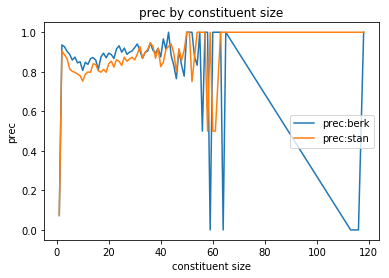

In [8]:
by_size = lambda cons: len(cons.span)
metrics_berk = metrics(gold= cons_gold, test= cons_berk, by= by_size)
metrics_stan = metrics(gold= cons_gold, test= cons_stan, by= by_size)
metrics_berk.columns = map("{}:berk".format, metrics_berk.columns)
metrics_stan.columns = map("{}:stan".format, metrics_stan.columns)
m = pd.concat((metrics_berk, metrics_stan), axis= 1, join= 'inner')
m.sort_index(axis= 0, inplace= True)
import matplotlib.pyplot as plt
for metric in 'f1', 'prec', 'recall':
    m[["{}:berk".format(metric), "{}:stan".format(metric)]].plot()
    plt.title("{} by constituent size".format(metric))
    plt.xlabel("constituent size")
    plt.ylabel(metric)
    plt.show()

<div class="alert alert-block alert-info">
**Accuracy by label** Which kinds of constituents are hard to predict? For each label type (S, NP, VP, PP, etc.), report the number of such constituents and parsing accuracy.
<div>

In [9]:
by_label = lambda cons: cons.label
metrics_berk = metrics(gold= cons_gold, test= cons_berk, by= by_label)
metrics_stan = metrics(gold= cons_gold, test= cons_stan, by= by_label)
metrics_berk.columns = map(lambda s: s[0] + ":berk", metrics_berk.columns)
metrics_stan.columns = map(lambda s: s[0] + ":stan", metrics_stan.columns)
labels = sorted({*metrics_berk.index, *metrics_stan.index})
cons_bl_gold = partition(cons_gold, by_label)
cons_bl_berk = partition(cons_berk, by_label)
cons_bl_stan = partition(cons_stan, by_label)
m = pd.concat(
    (metrics_berk, metrics_stan, pd.DataFrame(
        data= {'#': [len(cons_bl_gold[label]) for label in labels]
               , '#berk': [len(cons_bl_berk[label]) for label in labels]
               , '#stan': [len(cons_bl_stan[label]) for label in labels]}
        , index= labels))
    , axis= 1)
m.sort_values(by= '#', inplace= True)
m.sort_index(axis= 1, inplace= True)
print(m)

            #  #berk  #stan  f:berk  f:stan  p:berk  p:stan  r:berk  r:stan
PRT         0    127    158  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
INTJ        0      2      2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
X           1      0      1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
????        2      0      0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
WHADJP      2      4      5  0.6667  0.2857  0.5000  0.2000  1.0000  0.5000
LST         3      2      2  0.4000  0.8000  0.5000  1.0000  0.3333  0.6667
WHADVP      5     83     83  0.0227  0.0455  0.0120  0.0241  0.2000  0.4000
SBARQ       8      8      8  0.6250  0.5000  0.6250  0.5000  0.6250  0.5000
CONJP       8      8      5  0.7500  0.7692  0.7500  1.0000  0.7500  0.6250
FRAG       10     36     22  0.2609  0.1875  0.1667  0.1364  0.6000  0.3000
WHPP       11     12     11  0.9565  1.0000  0.9167  1.0000  1.0000  1.0000
SQ         14     12     11  0.6154  0.5600  0.6667  0.6364  0.5714  0.5000
UCP        1

<div class="alert alert-block alert-info">
**Discuss** Compare the results of the Berkeley and the Stanford parser. What did you learn by playing with the Stanford parser’s models and from the detailed accuracy plots? Which other tests may help you understand the strong and weak points of the different parsers?
</div>

It seems that both parsers perform more stably for constituents under size 50, and for larger constituents, the Stanford parser performs better than the Berkeley parser.  But the interpretation is difficult, since the constituents that span over entire sentences are always easier to get right.

When evaluated by labels, the scores have a positive correlation with the frequencies of the label.  (Spearman's rho 0.71 for `#` & `f:berk`, and 0.67 for `#` & `f:stan`.)

Other meaningful evaluations can be the run time and memory usage of the parsers.

## Problem 3: Dependency Grammar

<div class="alert alert-block alert-info">
Pick 3 test sentences and provide reasonable dependency structures for them. Briefly speculate: What are the advantages/disadvantages of dependency grammars over phrase structure grammars? What kinds of syntactic phenomena
can be captured more or less easily?
</div>

In [10]:
print(gold[382])
print(gold[571])
print(gold[653])

('NP', ('JJ', '382.0 Idle'), ('NN', '382.1 Thought'))
('NP', ('NNS', '571.0 Odds'), ('CC', '571.1 and'), ('NNS', '571.2 Ends'))
('ADVP', ('RB', '653.0 Absolutely'), ('RB', '653.1 not'), ('', '653.2 .'))


```
| id | form       | head |
|----+------------+------|
|  1 | Idle       |    1 |
|  2 | Thought    |    0 |
|----+------------+------|
|  1 | Odds       |    0 |
|  2 | and        |    3 |
|  3 | Ends       |    1 |
|----+------------+------|
|  1 | Absolutely |    0 |
|  2 | not        |    1 |
|  3 | .          |    1 |
```

* Easier to evaluate

A dependency tree for a sentence always has the same number of nodes and arcs as the length of the sentence, which makes evaluation easier compared to a constituency tree, since the number of constituents can be indefinite.

* Just DAGs

A dependency tree is simply a directed acyclic graph, so discoveries in graph theory can be readily applied.  Also due to the nice properties of DAGs, parsing with dependency grammar is possible in linear time with respect to the sentence length.

* Flexible

Dependency grammar can model long distance dependencies more easily, since an arc can reach any node in the sentence.  And if we want local properties, we could always impose projective properties.

It's easier to universally apply dependency grammar to different languages.  Highly synthetic languages have freer word order, so long distance dependencies are common.  Highly agglutinative languages often have clustered constituents, and dependency grammar is not obliged to make out the boundries, but only to identify the head.

* Less information

A dependency tree holds less information than a constituency tree.  It's possible to injectively map constituency trees to dependency trees, but not the other way around.

## Extra credit

<div class="alert alert-block alert-info">
Ideas for further work: testing additional parsers, testing the parsers on out-of-domain data.
</div>